In [44]:
!pip install openpyxl
!pip install transformers
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

from sklearn.model_selection import KFold
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
path = "/content/drive/MyDrive/Colab Notebooks/NLP/df_train_final.xlsx"
df_train = pd.read_excel(path)
df_train.columns = ['index','sentence','sentiment','topic']
df_train.drop(columns=['index'],inplace=True)
df_train.drop(columns=['topic'],inplace=True)

In [75]:
df_train


,sentence,sentiment,kfold
0,slide giáo_trình đầy_đủ,2,0.0
1,nhiệt_tình giảng_dạy gần_gũi với sinh_viên,2,0.0
2,đi học đầy_đủ full điểm chuyên cần,0,0.0
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...,0,0.0
4,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...,2,0.0
...,...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0,4.0
11422,em cảm_ơn cô nhiều,2,4.0
11423,giao bài_tập quá nhiều,0,4.0
11424,giáo_viên dạy dễ hiểu nhiệt_tình,2,4.0


In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

In [ ]:
device

device(type='cuda')

In [74]:
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=df_train, y=df_train.sentiment)):
    df_train.loc[val_, "kfold"] = fold

In [53]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=250):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['sentence']
        text = ' '.join(simple_preprocess(text))
        label = row['sentiment']

        return text, label

In [72]:
class phoBertModel(nn.Module):
    def __init__(self, n_classes):
        super(phoBertModel, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")

        self.bert_clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.bert.config.hidden_size, 256)
        )
        self.final_clf = nn.Sequential(
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.Softmax()
        )
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )
        x = self.bert_clf(output)



        x = self.final_clf(x)
        return x





In [61]:
class phoBert_LSTM_Model(nn.Module):
    def __init__(self, n_classes):
        super(phoBert_LSTM_Model, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")


        self.bert_clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.bert.config.hidden_size, 512)
        )

        self.lstm = nn.LSTM(512,256, num_layers = 2, dropout = 0.2, bidirectional = True)


        self.final_clf = nn.Sequential(
            nn.Linear(512, 256),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.Softmax()
        )
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.bert_clf(output)
        x, hidden = self.lstm(x)

        #lstm_out, hidden = self.lstm(x)

        #lstm_out = lstm_out.contiguous().view(-1, 256)

        x = self.final_clf(x)
        return x





In [56]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [57]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0



    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

Text(0.5, 9.444444444444438, 'Token Count')

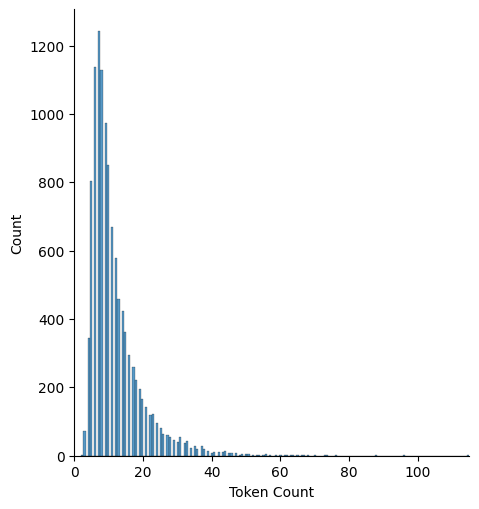

In [58]:
all_data = df_train.sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [76]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=50)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=50)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [77]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(df_train, fold=fold)
    model = phoBertModel(n_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.6312910284463895 Loss: 0.9079237153063288
Valid Accuracy: 0.926071741032371 Loss: 0.6353519417189218
Epoch 2/6
------------------------------
Train Accuracy: 0.9157549234135668 Loss: 0.638760948306197
Valid Accuracy: 0.9295713035870516 Loss: 0.6225501553161995
Epoch 3/6
------------------------------
Train Accuracy: 0.9239606126914661 Loss: 0.6283793075309767
Valid Accuracy: 0.9111986001749781 Loss: 0.6403983414589942
Epoch 4/6
------------------------------
Train Accuracy: 0.9216630196936543 Loss: 0.6302737473816304
Valid Accuracy: 0.9273840769903763 Loss: 0.6244263102958253
Epoch 5/6
------------------------------
Train Accuracy: 0.9284463894967178 Loss: 0.6234651266278087
Valid Accuracy: 0.9308836395450569 Loss: 0.6206009988184575
Epoch 6/6
------------------------------
Train Accuracy: 0.9283369803063458 Loss: 0.6231069456447255
Valid Accuracy: 0.9308836395450569 Loss: 0.620708830706723

KeyboardInterrupt: ignored

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/NLP/df_test_final.xlsx"
df_test = pd.read_excel(path)
df_test.columns = ['index','sentence','sentiment','topic']
df_test.drop(columns=['index'],inplace=True)
df_test.drop(columns=['topic'],inplace=True)

In [69]:
df_test

,sentence,sentiment
0,nói tiếng anh lưu_loát .,2
1,giáo_viên rất vui_tính .,2
2,cô max có tâm .,2
3,"giảng bài thu_hút , dí_dỏm .",2
4,"giáo_viên không giảng_dạy kiến_thức , hướng_dẫ...",0
...,...,...
3161,"các slide khó hiểu , ngôn_ngữ trong slide phức...",0
3162,giáo_viên giảng_dạy có tâm_huyết .,2
3163,chia_sẻ cho em nhiều điều hay .,2
3164,em tiếp_thu chậm .,0


In [ ]:
def test(data_loader):
    models = []
    for fold in range (skf.n_splits):
        model = phoBert_LSTM_Model(n_classes=3)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim = 1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts




In [ ]:
test_dataset = SentimentDataset(df_test, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label



wrong_arr, wrong_label = check_wrong(real_values, predicts)
for i in range(len(wrong_arr)):
    print('-'*50)
    print(df_test.iloc[wrong_arr[i]].sentence)
    print(f'{wrong_label[i]} vs {real_values[wrong_arr[i]]}')